In [1]:
import importlib
import os
import fnmatch
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import csv
from sklearn import tree
import sys
sys.stdout.flush()
import math
import matplotlib.pyplot as plt

In [2]:
clean_belloni = open('1915Belloniclass_updated.dat')
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

available = []
pool=[]

#/home/jkok1g14/Documents/GRS1915+105/data
#/export/data/jakubok/GRS1915+105/Std1_PCU2
for root, dirnames, filenames in os.walk("/home/jkok1g14/Documents/GRS1915+105/data/Std1_PCU2"):
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        available.append(filename)
for ob, state in ob_state.items():
    if ob+"_std1_lc.txt" in available:
        pool.append(ob)  

#create a list of arrays with time and counts for the set of Belloni classified observations
lc_dirs=[]
lcs=[]
ids=[]
for root, dirnames, filenames in os.walk("/home/jkok1g14/Documents/GRS1915+105/data/Std1_PCU2"):    
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        if filename.split("_")[0] in pool:
            lc_dirs.append(os.path.join(root, filename))

            
#make 2D arrays for light curves, with columns of counts and time values
for lc in lc_dirs:
    ids.append(lc.split("/")[-1].split("_")[0])
    f=np.loadtxt(lc)
    f=np.transpose(f)#,axis=1)
    f=f[0:2]
    ###1s average and time check to eliminate points outside of GTIs
    f8t = np.mean(f[0][:(len(f[0])//8)*8].reshape(-1, 8), axis=1)
    f8c = np.mean(f[1][:(len(f[1])//8)*8].reshape(-1, 8), axis=1)
    f8c=f8c-np.mean(f8c)#normalisation/mean centering/whatever you desire most
    rm_points = []
    skip=False
    for i in range(len(f8t)-1):
        if skip==True:
            skip=False
            continue
        delta = f8t[i+1]-f8t[i]
        if delta > 1.0:
            rm_points.append(i+1)
            skip=True
            
####### normalise the count rates! think about the effect of 0-1 normalisation on the distance calculation
            
    times=np.delete(f8t,rm_points)
    counts=np.delete(f8c,rm_points)
    lcs.append(np.stack((times,counts)))
    
lc_classes=[]
for i in ids:
    lc_classes.append(ob_state[i])
lc_classes

drop_classes=[]
for clas, no in Counter(lc_classes).items():
    if no<7:
        drop_classes.append(clas)

lcs_abu = []
classes_abu = []
ids_abu = []
for n, lc in enumerate(lc_classes):
    if lc not in drop_classes:
        classes_abu.append(lc)
        lcs_abu.append(lcs[n])
        ids_abu.append(ids[n])  
x_train, x_test, y_train, y_test, id_train, id_test = train_test_split(lcs_abu, classes_abu, ids_abu, test_size=0.5, random_state=0, stratify=classes_abu)

In [123]:
#segmentation of the ts
def segmentation(ts, seg_len, seg_slide, time_stamps=True):
    """ts=time series, seg_len=size of the moving window, seg_slide=difference in the starting position of the consecutive windows"""
    segments=[]
    if time_stamps==True:
        for start in range(0, len(ts[0])-seg_len, seg_slide):
            end=start+seg_len
            if ts[0][end]-ts[0][start] != seg_len: ####don't allow segments with missing data
                continue
            segments.append(np.copy(ts[:,start:end]))
        return segments
    else:
        for start in range(0, len(ts[0])-seg_len, seg_slide):
            end=start+seg_len
            if ts[0][end]-ts[0][start] != seg_len: ####don't allow segments with missing data
                continue
            segments.append(np.copy(ts[1][start:end]))
        return segments

#multiplication of the segments by a waveform to emphesise the features in the centre and zero the ends so that the segments can be joined smoothely together
def center_offset(segments, ts, time_stamps=True, offset=True):
    c_segments=[]
    if time_stamps==True:
        window_rads = np.linspace(0, np.pi, len(segments[0][0]))
        window_sin = np.sin(window_rads)**2
        if offset==True:
            for segment in segments:
                segment[1]*=window_sin
                segment[0]-=ts[0][0]
                c_segments.append(segment)
            return c_segments
        else:
            for segment in segments:
                segment[1]*=window_sin
                c_segments.append(segment)
            return c_segments
    else:
        window_rads = np.linspace(0, np.pi, len(segments[0]))
        window_sin = np.sin(window_rads)**2
        for segment in segments:
            segment*=window_sin
            c_segments.append(segment)
        return c_segments

def reconstruct(test_segments, test_ts, kmeans_model, offset=True):
    reco= np.zeros(np.shape(test_ts))
    reco[0]=np.copy(test_ts[0])
    if offset == True:
        offset_val=0
        reco[0]-=test_ts[0][0]
    else:
        offset_val=test_ts[0][0]
    centroids=kmeans_model.cluster_centers_
    if np.shape(test_segments)[1] == 2:
        correction=0
        for segment in test_segments:
            pred_centroid=cluster.predict(np.array(segment[1]).reshape(1, -1))[0]
            start=int(segment[0,0]-offset_val-correction)
            end=int(segment[0,-1]+1-offset_val-correction)
            if reco[0,start]-start != correction:
                correction=reco[0,start]-start
                start=int(segment[0,0]-offset_val-correction)
                end=int(segment[0,-1]+1-offset_val-correction)
            reco_seg=reco[1][start:end]
            reco[1,start:end]+=centroids[pred_centroid][0:len(reco_seg)]
        return reco
    else:
        correction=0
        print(np.shape(test_segments))
        seg_slide=25
        for n_seg, segment in enumerate(test_segments):
            pred_centroid=cluster.predict(np.array(segment).reshape(1, -1))[0]
            start=n_seg*seg_slide
            end=start+len(segment)
            reco[start:end]+=centroids[pred_centroid]
        return reco

In [130]:
from sklearn.cluster import KMeans
cluster=KMeans(n_clusters=100)
# training and test time series, both time[0] and count rate[1]
train_ts=x_train[0]
test_ts=x_train[0]

offset=True
time_stamps=True

#train the model
train_segments=segmentation(train_ts, 50, 2, time_stamps=time_stamps)
c_train_segments=center_offset(train_segments, train_ts, offset=offset, time_stamps=time_stamps)
cluster.fit(np.array(c_train_segments)[:,1])

#test segments
test_segments= segmentation(test_ts, 50, 25, time_stamps=time_stamps)
c_test_segments=center_offset(test_segments, test_ts, offset=offset, time_stamps=time_stamps)

#reconstruct the test time series
reco = reconstruct(c_test_segments, test_ts, cluster, offset=offset)

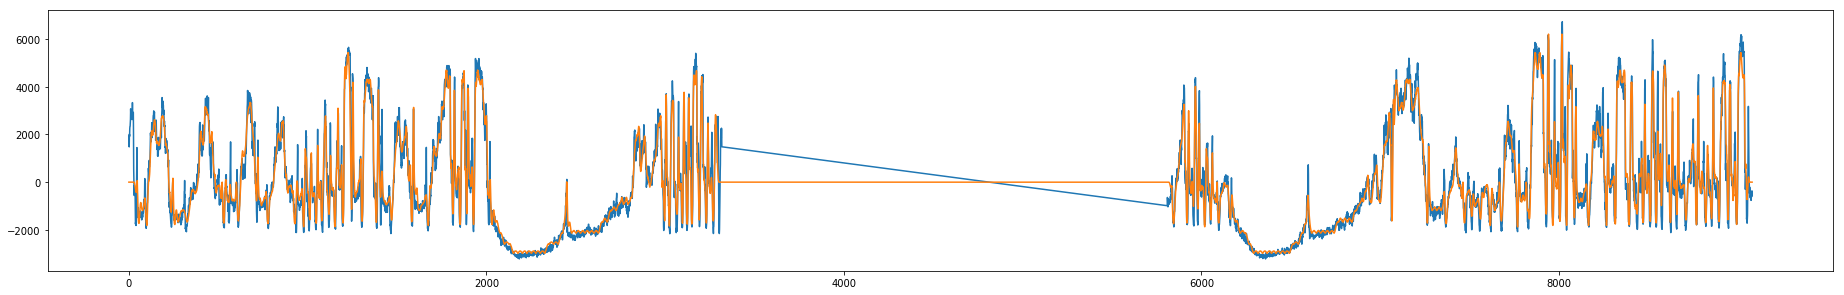

In [131]:
plt.figure(figsize=(6.4*5, 4.8))
plt.plot(test_ts[0]-(test_ts[0][0]*offset),test_ts[1])
plt.plot(reco[0],reco[1])
#plt.plot(reco[0],reco[1]-test_ts[1])

plt.show()

In [116]:
np.shape(c_test_segments)[1]

2

In [55]:
a=129
c_test_segments[a+1][0][0]-c_test_segments[a][0][0]


2565.5

In [56]:
c_test_segments[129]

array([[ 7.57526317e+07,  7.57526327e+07,  7.57526337e+07,
         7.57526347e+07,  7.57526357e+07,  7.57526367e+07,
         7.57526377e+07,  7.57526387e+07,  7.57526397e+07,
         7.57526407e+07,  7.57526417e+07,  7.57526427e+07,
         7.57526437e+07,  7.57526447e+07,  7.57526457e+07,
         7.57526467e+07,  7.57526477e+07,  7.57526487e+07,
         7.57526497e+07,  7.57526507e+07,  7.57526517e+07,
         7.57526527e+07,  7.57526537e+07,  7.57526547e+07,
         7.57526557e+07,  7.57526567e+07,  7.57526577e+07,
         7.57526587e+07,  7.57526597e+07,  7.57526607e+07,
         7.57526617e+07,  7.57526627e+07,  7.57526637e+07,
         7.57526647e+07,  7.57526657e+07,  7.57526667e+07,
         7.57526677e+07,  7.57526687e+07,  7.57526697e+07,
         7.57526707e+07,  7.57526717e+07,  7.57526727e+07,
         7.57526737e+07,  7.57526747e+07,  7.57526757e+07,
         7.57526767e+07,  7.57526777e+07,  7.57526787e+07,
         7.57526797e+07,  7.57526807e+07],
       [-0.00

In [57]:
c_test_segments[130]

array([[ 7.57551972e+07,  7.57551982e+07,  7.57551992e+07,
         7.57552002e+07,  7.57552012e+07,  7.57552022e+07,
         7.57552032e+07,  7.57552042e+07,  7.57552052e+07,
         7.57552062e+07,  7.57552072e+07,  7.57552082e+07,
         7.57552092e+07,  7.57552102e+07,  7.57552112e+07,
         7.57552122e+07,  7.57552132e+07,  7.57552142e+07,
         7.57552152e+07,  7.57552162e+07,  7.57552172e+07,
         7.57552182e+07,  7.57552192e+07,  7.57552202e+07,
         7.57552212e+07,  7.57552222e+07,  7.57552232e+07,
         7.57552242e+07,  7.57552252e+07,  7.57552262e+07,
         7.57552272e+07,  7.57552282e+07,  7.57552292e+07,
         7.57552302e+07,  7.57552312e+07,  7.57552322e+07,
         7.57552332e+07,  7.57552342e+07,  7.57552352e+07,
         7.57552362e+07,  7.57552372e+07,  7.57552382e+07,
         7.57552392e+07,  7.57552402e+07,  7.57552412e+07,
         7.57552422e+07,  7.57552432e+07,  7.57552442e+07,
         7.57552452e+07,  7.57552462e+07],
       [-0.00